<a href="https://colab.research.google.com/github/LariouchOussama/Applied-Data-Science-Capstone/blob/main/Effyisdatachallange.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


In [ ]:
# Load the dataset
df = pd.read_csv('train_test_data.csv')

In [ ]:
# Data wrangling and preparation
df['Date'] = pd.to_datetime(df['Date'])
data = df[['Date', 'amount_transaction']]
data.columns = ['ds', 'y']

In [ ]:
# Initialize and fit the model
model = Prophet()
model.fit(data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw1ot39e/ao2l03li.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplw1ot39e/zpnfby81.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78532', 'data', 'file=/tmp/tmplw1ot39e/ao2l03li.json', 'init=/tmp/tmplw1ot39e/zpnfby81.json', 'output', 'file=/tmp/tmplw1ot39e/prophet_modelg6lycwmh/prophet_model-20231123145036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:50:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:50:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Create future dates for forecasting
future = model.make_future_dataframe(periods=30)  # Assuming 30 days of forecasting


In [ ]:

# Make predictions
forecast = model.predict(future)

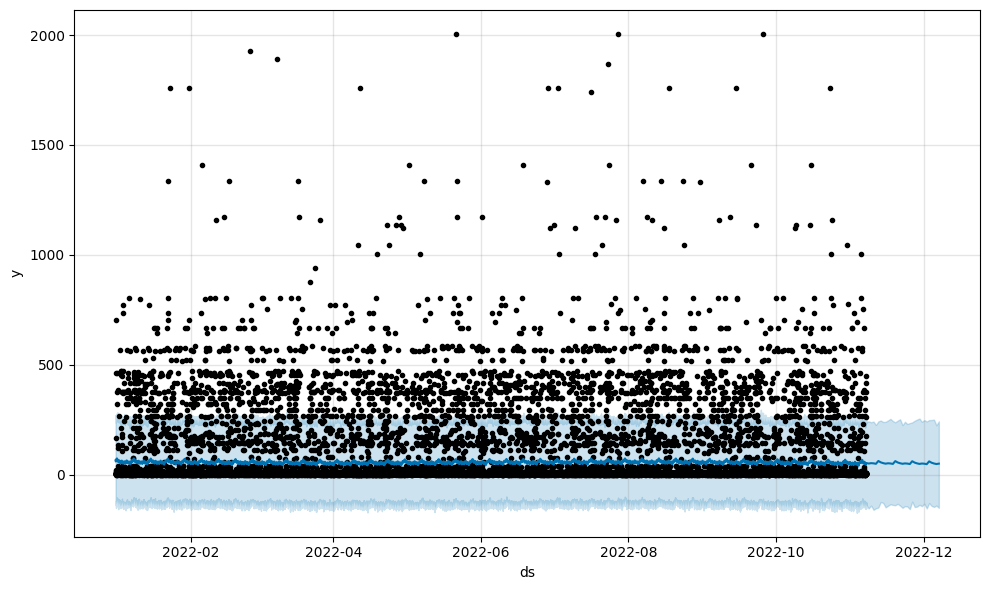

In [ ]:
# Visualize the forecast
fig = model.plot(forecast)
plt.show()

In [ ]:
# Define test dates as the last 30 days of the dataset
test_dates = df['Date'].sort_values().unique()[-30:]


In [ ]:
actual_values = df['amount_transaction'].loc[df['Date'].isin(test_dates)]


In [ ]:
actual_values = df['amount_transaction'].loc[df['Date'].isin(test_dates)]


In [ ]:
# Calculate the sMAPE
n = len(actual_values)
smape = (1/n) * sum(2 * abs(forecast['yhat'] - actual_values) / (abs(actual_values) + abs(forecast['yhat'])) * 100)


In [ ]:
# Print the sMAPE
print(f"sMAPE: {smape:.2f}%")


sMAPE: nan%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
file_path = 'train_test_data.csv'

# Read CSV and parse dates in one step
df = pd.read_csv(file_path, parse_dates=['Date'])

# Combine groupby and aggregation in a single step
df = df.groupby(['Id_compte', df['Date'].dt.date]).agg(amount_transaction=('amount_transaction', 'sum')).reset_index()

# Set the Date column as the index
df.set_index('Date', inplace=True)

# Convert the index to datetime if it's not already
df.index = pd.to_datetime(df.index)

# Optional: Sort the index if it's not already sorted
df.sort_index(inplace=True)

df

,Id_compte,amount_transaction
Date,,
2022-01-01,CPA.1,10.34
2022-01-01,HP.1,336.60
2022-01-01,IPA.1,22.06
2022-01-01,SEW0C_HI.1,33.44
2022-01-01,SEW0C_LI.1,19.15
...,...,...
2022-11-07,CPA_MP.1,8.79
2022-11-07,SEW0C_HI.1,461.52
2022-11-07,SEWC_P.1,650.16


In [ ]:

def create_features(df):

    le = LabelEncoder()
    df['Id_compte_encoded'] = le.fit_transform(df['Id_compte'])
    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
    df=df.drop(columns=['Id_compte'])
    return df,le

df,le=create_features(df)

In [ ]:

# Train-Test Split
train_end_date = '2022-09-30'
train_data = df[df.index <= train_end_date]
test_data = df[df.index > train_end_date]

In [ ]:
features = [col for col in df.columns if col != 'amount_transaction']
target = 'amount_transaction'
# Split into X (features) and y (target)
X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

model = XGBRegressor(learning_rate= 0.1, max_depth= 3, n_estimators=50)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Predictions
y_pred = model.predict(X_test)

Mean Absolute Error: 255.28389849464364


<ipython-input-48-f5763f5374df>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = model.predict(X_test)


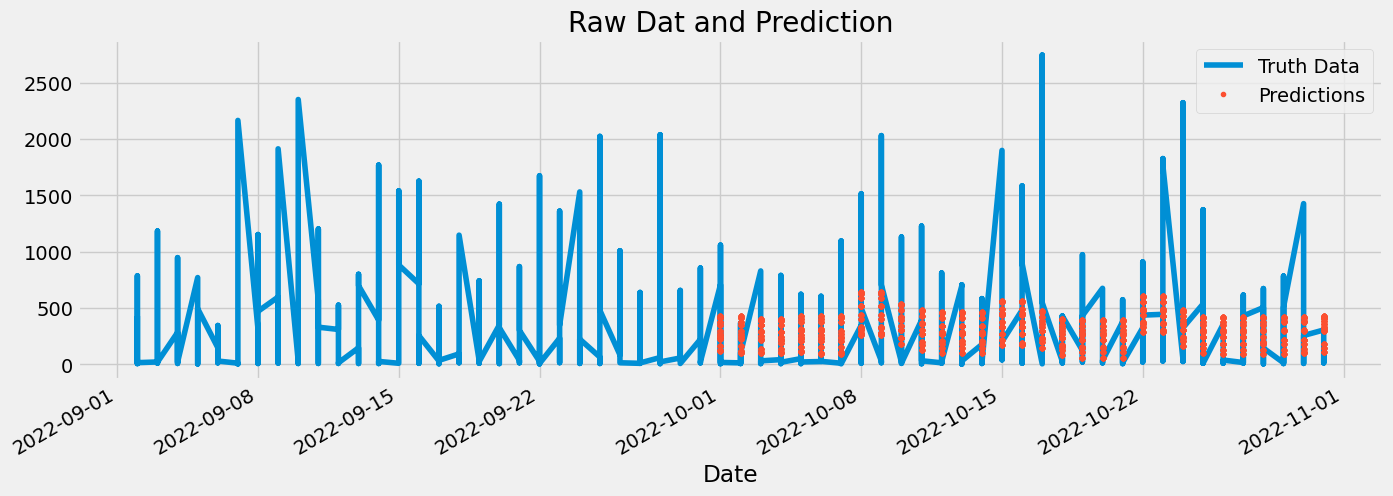

In [ ]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

a=df.loc[(df.index > '2022-09-01') & (df.index < '2022-11-01')]

test_data['prediction'] = model.predict(X_test)
a = a.merge(test_data[['prediction']], how='left', left_index=True, right_index=True)
ax = a[['amount_transaction']].plot(figsize=(15, 5))
a['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()



In [ ]:
f = df[df['Id_compte_encoded'] == 6]

f=f.loc[(f.index > '2022-10-01') & (f.index < '2022-11-01')]

result = seasonal_decompose(f['amount_transaction'], model='additive', period=30)  # Adjust the period based on your monthly seasonality
plt.figure(figsize=(400, 90))
result.plot()
plt.suptitle('Time Series Decomposition')
plt.show()


ValueError: ignored

<ipython-input-50-252baac92201>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = model.predict(X_test)


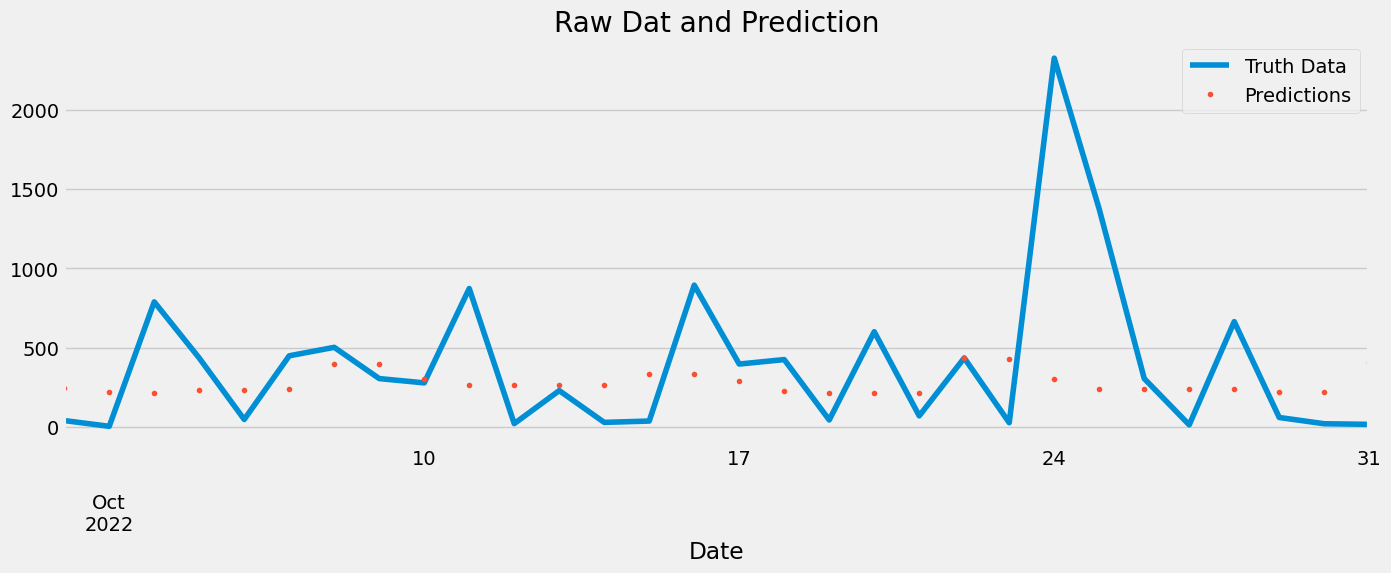

In [ ]:
test_data = test_data[test_data['Id_compte_encoded'] == 2]
X_test = X_test[X_test['Id_compte_encoded'] == 2]
test_data['prediction'] = model.predict(X_test)
f = f.merge(test_data[['prediction']], how='left', left_index=True, right_index=True)
ax = f[['amount_transaction']].plot(figsize=(15, 5))
f['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [ ]:
X_test

# Generating Predictions for the Evaluation Period
# Creating a dataframe for prediction dates
prediction_dates = pd.date_range(start='2022-11-01', end='2022-12-3')


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
# Load the data
df = pd.read_csv('train_test_data.csv', parse_dates=['Date'])

FileNotFoundError: ignored